# House Price Prediction in Nigeria

This notebook covers exploratory data analysis, preprocessing, modeling, and evaluation for predicting house prices in Nigeria.


## 1. Import Required Libraries

We will use pandas, numpy, matplotlib, seaborn, and scikit-learn for data analysis and modeling.

In [13]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## 2. Load and Explore the Dataset

Load the Nigeria house prices dataset and display basic information.

In [14]:
# Load the dataset
df = pd.read_csv("../data/nigeria_houses_data.csv")
df.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
0,6.0,5.0,5.0,4.0,Detached Duplex,Mabushi,Abuja,450000000.0
1,4.0,5.0,5.0,4.0,Terraced Duplexes,Katampe,Abuja,800000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0


### 2.1 Data Structure and Missing Values

Check the dataframe's shape, info, and count missing values.

In [15]:
# DataFrame info and shape
print("Shape:", df.shape)
df.info()

Shape: (24326, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24326 entries, 0 to 24325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24326 non-null  float64
 1   bathrooms      24326 non-null  float64
 2   toilets        24326 non-null  float64
 3   parking_space  24326 non-null  float64
 4   title          24326 non-null  object 
 5   town           24326 non-null  object 
 6   state          24326 non-null  object 
 7   price          24326 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.5+ MB


In [16]:
# Count missing values for each column
df.isnull().sum()

bedrooms         0
bathrooms        0
toilets          0
parking_space    0
title            0
town             0
state            0
price            0
dtype: int64

### 2.2 Visualize Target Variable Distribution

Plot the distribution of the 'price' column and its log-transformed version.

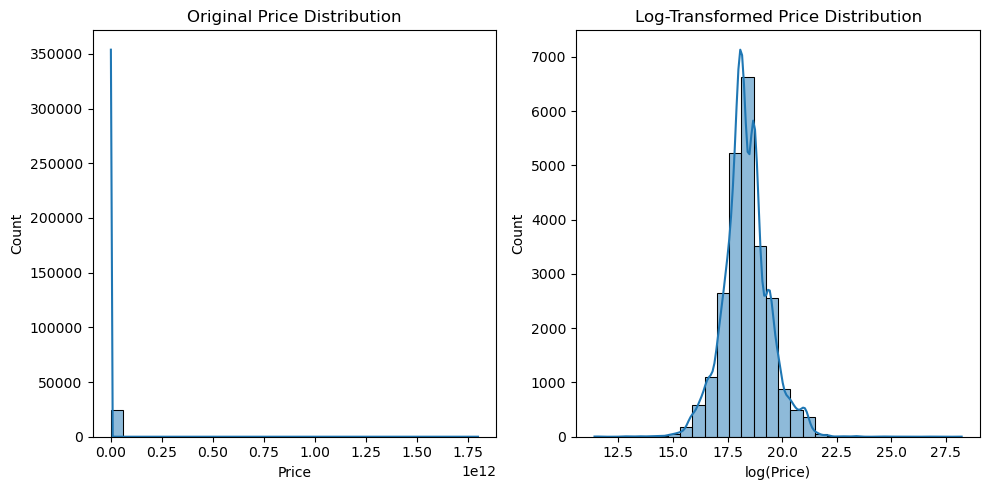

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Original Price Distribution')
plt.xlabel('Price')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['price']), bins=30, kde=True)
plt.title('Log-Transformed Price Distribution')
plt.xlabel('log(Price)')
plt.tight_layout()
plt.show()

### 2.3 Analyze Categorical Features

Display the most common states in the dataset.

In [17]:
# Top 10 states by count
state_counts = df['state'].value_counts().head(10)
print(state_counts)

state
Lagos       18445
Abuja        3524
Ogun          637
Oyo           477
Rivers        444
Imo           246
Anambara      145
Enugu         128
Edo           100
Delta          63
Name: count, dtype: int64


## 3. Data Preprocessing

Prepare data for modeling: define features and target, then split into train/test sets.

In [18]:
target_col = 'price'

In [19]:
exclude = ['id'] if 'id' in df.columns else []
feature_cols = [c for c in df.columns if c not in exclude + [target_col]]

X = df[feature_cols].copy()
y = df[target_col].copy()

### 3.1 Train-Test Split

Split data into training (80%) and testing (20%) sets to prevent data leakage.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [31]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

### 3.2 Identify Numeric and Categorical Columns

Separate features by data type for appropriate preprocessing.

In [22]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
], remainder='drop')


## 5. Train the Model

Create and train a Ridge Regression model with log-transformed target.

In [23]:
y_train_log = np.log1p(y_train)

model = Pipeline([
    ('preproc', preprocessor),
    ('reg', LinearRegression())
])

## 6. Evaluate Model Performance

Generate predictions and calculate performance metrics on the test set.

In [24]:
model.fit(X_train, y_train_log)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'toilets',
                                                   'parking_space']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['title', 'town',
                                                   'state'])])),
                ('reg', LinearRegression())])

In [25]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

C:\Users\Vinfotech\AppData\Local\Temp\ipykernel_20048\1337767581.py:2: RuntimeWarning: overflow encountered in expm1
  y_pred = np.expm1(y_pred_log)


In [27]:
from sklearn.linear_model import Ridge

model = Pipeline([
    ('preproc', preprocessor),
    ('reg', Ridge(alpha=1.0))  # Regularization reduces extreme predictions
])

model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE (original units): {rmse:.2f}")
print(f"R^2: {r2:.3f}")

RMSE (original units): 204716075.28
R^2: 0.490


### 6.1 Cross-Validation Score

Validate model performance using 5-fold cross-validation.

In [32]:
cv_scores = cross_val_score(model, X_train, y_train_log, scoring='neg_root_mean_squared_error', cv=5)
cv_rmse = -cv_scores.mean()
cv_std = cv_scores.std()

print("=" * 50)
print("CROSS-VALIDATION RESULTS (5-Fold)")
print("=" * 50)
print(f"Mean CV RMSE (log-target): {cv_rmse:.4f}")
print(f"Std Dev: {cv_std:.4f}")
print("=" * 50)

CROSS-VALIDATION RESULTS (5-Fold)
Mean CV RMSE (log-target): 0.6271
Std Dev: 0.0309


### 6.2 Residual Analysis

Analyze model residuals to check for patterns and assumptions.

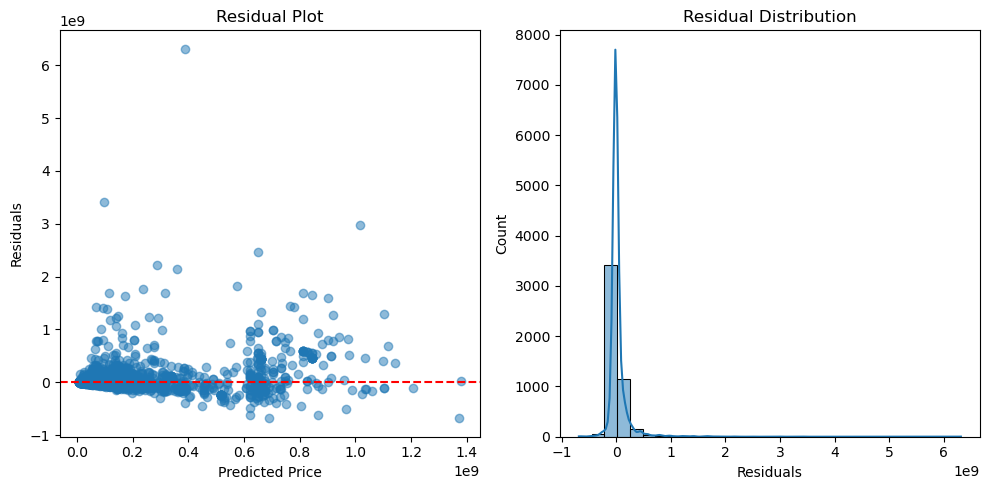

In [30]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()

## 7. Conclusion and Next Steps

We successfully built a house price prediction model using Ridge Regression with proper preprocessing pipelines. The model was trained on log-transformed prices to handle the skewed distribution.

### Key Achievements:
- ✅ Proper data leakage prevention (train/test split before preprocessing)
- ✅ Robust handling of missing values and categorical encoding
- ✅ Log-transformation to normalize target variable
- ✅ Cross-validation for stable performance estimation
- ✅ Residual analysis for model diagnostics

### Future Improvements:
- Try advanced models (Random Forest, XGBoost, Gradient Boosting)
- Hyperparameter tuning (Grid Search / Random Search)
- Feature importance analysis
- Outlier detection and handling
- Target encoding for high-cardinality categorical features